In [ ]:
%%capture
"""
------------------------------------------------------------------------------------------------------------------------
Code used to perform the nested N-spheres experiment with NODEs and ANODEs. This was taken from Alex's GitHub:
https://github.com/a-norcliffe/sonode/blob/master/experiments/nested-n-spheres/nested-n-spheres_anode.py

I have also made some small modifications that save the model at given iterations, which can then be used for
Hessian analysis.
------------------------------------------------------------------------------------------------------------------------
"""

In [ ]:
%%capture
pip install torchdiffeq

In [49]:
import time
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=False)
parser.add_argument('--visualise', type=eval, default=True)
parser.add_argument('--niters', type=int, default=600)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--extra_dim', type=int, default=1)
parser.add_argument('--data_dimension', type=int, default=2)
parser.add_argument('--npoints', type=int, default=50)
parser.add_argument('--ntest', type=int, default=10)
parser.add_argument('--hessian_freq', type=int, default=20)
args = parser.parse_args(args=[])

args.hessian_freq = 5
args.extra_dim = 1
args.visualise = False

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [ ]:
class ODEfunc(nn.Module):
    """
    Neural network to parametrise the derivative of the state vector. Maps from [dim] to [dim] dimensions.
    """
    def __init__(self, dim, nhidden):
        super(ODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out
    

class ODEBlock(nn.Module):
    """
    Defines the entire ODE block that acts on the state vector, i.e. it perfoms integration on the state vector
    with the derivative given by an ODEFunc() object, and interval given by [t0, tN].
    """
    def __init__(self, odefunc, t0_, tN_):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_times = torch.tensor([t0_, tN_]).float()
        
    def forward(self, x):
        out = odeint(self.odefunc, x, self.integration_times, rtol=args.tol, atol=args.tol)
        out = out[1]
        return out

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

In [ ]:
class Decoder(nn.Module):
    """
    Function that maps 2D output to a scalar (i.e. 1D vector). The output is then compared to the desired value
    (either 1 or -1).
    """
    def __init__(self, in_dim, out_dim):          #out_dim = 1.
        super(Decoder, self).__init__()
        self.tanh = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, z):
        out = self.fc(z)
        out = self.tanh(out)
        return out


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [50]:
if __name__ == '__main__':
    device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
    if args.extra_dim == 0:
        filename = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/node/'
        models_filename = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/node/models/'
    else:
        filename = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/anode('+str(args.extra_dim)+')/'
        models_filename = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/anode('+str(args.extra_dim)+')/models/'
    try:
        os.makedirs(filename)
        
    except FileExistsError:
        pass

    try:
        os.makedirs(models_filename)
        
    except FileExistsError:
        pass

    dim = args.data_dimension + args.extra_dim
    
    #Download data
    name_in = str(args.data_dimension)+'din_'+str(args.npoints)+'_train.npy'        #Only use the training data.
    name_out = str(args.data_dimension)+'dout_'+str(args.npoints)+'_train.npy'
    folder_name = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/data/'
    z0 = torch.tensor(np.load(folder_name+name_in)).float().to(device)
    zN = torch.tensor(np.load(folder_name+name_out)).float().to(device)
    
    #Augment z0
    zeros = torch.zeros(args.npoints, args.extra_dim).float()
    z0 = torch.cat((z0, zeros), dim=1).to(device)

    # model
    t0, tN = 0, 1
    nhidden = 20
    feature_layers = [ODEBlock(ODEfunc(dim, nhidden), t0, tN), Decoder(dim, 1)]
    model = nn.Sequential(*feature_layers).to(device)         #the * bit means that only the elements of the list are taken.
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    loss_func = nn.MSELoss()
    
    itr_arr = np.empty(args.niters)
    loss_arr = np.empty(args.niters)
    nfe_arr = np.empty(args.niters)
    time_arr = np.empty(args.niters)

    # training
    start_time = time.time()
    torch.save(model, models_filename + 'model_0.pt')
    for itr in range(1, args.niters + 1):
        feature_layers[0].nfe = 0
        iter_start_time = time.time()
        optimizer.zero_grad()

        # forward in time and solve ode
        pred_z = model(z0)
        # compute loss
        loss = loss_func(pred_z, zN)
        loss.backward()
        optimizer.step()
        iter_end_time = time.time()
        #make arrays
        itr_arr[itr-1] = itr
        loss_arr[itr-1] = loss
        nfe_arr[itr-1] = feature_layers[0].nfe
        time_arr[itr-1] = iter_end_time-iter_start_time 

        if itr % args.hessian_freq == 0:
          torch.save(model, models_filename + 'model_' + str(itr) + '.pt')
        else:
          pass

        print('Iter: {}, running MSE: {:.4f}'.format(itr, loss))
            

    end_time = time.time()
    print('\n')
    print('Training complete after {} iters.'.format(itr))
    print('Time = ' + str(end_time-start_time))
    loss = loss_func(pred_z, zN).detach().numpy()
    print('Train MSE = ' +str(loss))
    print('NFE = ' +str(feature_layers[0].nfe))
    print('Parameters = '+str(count_parameters(model)))
    
    np.save(filename+'itr_arr.npy', itr_arr)
    np.save(filename+'nfe_arr.npy', nfe_arr)
    np.save(filename+'loss_arr.npy', loss_arr)
    np.save(filename+'time_arr.npy', time_arr)
    torch.save(model, filename+'model.pth')
    
    # make test data
    name_in = str(args.data_dimension)+'din_'+str(args.ntest)+'_test.npy'
    name_out = str(args.data_dimension)+'dout_'+str(args.ntest)+'_test.npy'
    folder_name = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/data/'
    z0 = torch.tensor(np.load(folder_name+name_in)).float().to(device)
    zN = torch.tensor(np.load(folder_name+name_out)).float().to(device)
    # augment z0
    zeros = torch.zeros(args.ntest, args.extra_dim).float()
    z0 = torch.cat((z0, zeros), dim=1).to(device)
    
    # run test data through network
    pred_z = model(z0)

    # compute loss
    loss = loss_func(pred_z, zN).detach().numpy()
    print('Test MSE = ' +str(loss))
    
    if args.visualise:
        try:
            os.makedirs('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/figure_data/')
        except FileExistsError:
            pass
        #Generate a sequence of timepoints, such that the model can be evaluated at intermediate times during integration.   
        samp_ts = torch.linspace(t0, tN, 30)
        if args.data_dimension == 1:
            z0 = torch.tensor(np.load(  '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/data'
                                      + '/vis_data/1d_vis_data.npy')).float()
            ntotal = len(z0)
            #Augment z0
            zeros = torch.zeros(ntotal, args.extra_dim).float()
            z0 = torch.cat((z0, zeros), dim=1).to(device)
            pred_z = odeint(feature_layers[0].odefunc, z0, samp_ts)
            pred_z = pred_z.detach().numpy()
            if args.extra_dim == 0:
                name =  ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/figure_data'
                        + '/node_film_1d.npy')
            else:
                name =  ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2'
                        + '/figure_data/anode_film_(1+'+str(args.extra_dim)+')d.npy')
            np.save(name, pred_z)
        elif args.data_dimension == 2:
            z0 = torch.tensor(np.load(  '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/data'
                                      + '/vis_data/2d_vis_data.npy')).float()
            ntotal = len(z0)
            #Augment z0
            zeros = torch.zeros(ntotal, args.extra_dim).float()
            z0 = torch.cat((z0, zeros), dim=1).to(device)
            pred_z = odeint(feature_layers[0].odefunc, z0, samp_ts)
            pred_z = pred_z.detach().numpy()
            if args.extra_dim == 0:
                name = ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/figure_data'
                        + '/node_film_2d.npy')
            else:
                name = ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/figure_data'
                        + '/anode_film_(2+'+str(args.extra_dim)+')d.npy')
            np.save(name, pred_z)
        elif args.data_dimension == 3:
            z0 = torch.tensor(np.load(  '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/data'
                                      + '/vis_data./3d_vis_data.npy')).float()
            ntotal = len(z0)
            #Augment z0
            zeros = torch.zeros(ntotal, args.extra_dim).float()
            z0 = torch.cat((z0, zeros), dim=1).to(device)
            pred_z = odeint(feature_layers[0].odefunc, z0, samp_ts)
            pred_z = pred_z.detach().numpy()
            if args.extra_dim == 0:
                name = ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_2/figure_data'
                        + '/node_film_3d.npy')
            else:
                pass
            np.save(name, pred_z)
        else:
            pass


Iter: 1, running MSE: 1.0487
Iter: 2, running MSE: 1.0102
Iter: 3, running MSE: 0.9872
Iter: 4, running MSE: 0.9760
Iter: 5, running MSE: 0.9715
Iter: 6, running MSE: 0.9674
Iter: 7, running MSE: 0.9607
Iter: 8, running MSE: 0.9523
Iter: 9, running MSE: 0.9443
Iter: 10, running MSE: 0.9383
Iter: 11, running MSE: 0.9342
Iter: 12, running MSE: 0.9303
Iter: 13, running MSE: 0.9246
Iter: 14, running MSE: 0.9165
Iter: 15, running MSE: 0.9069
Iter: 16, running MSE: 0.8971
Iter: 17, running MSE: 0.8872
Iter: 18, running MSE: 0.8748
Iter: 19, running MSE: 0.8590
Iter: 20, running MSE: 0.8422
Iter: 21, running MSE: 0.8267
Iter: 22, running MSE: 0.8120
Iter: 23, running MSE: 0.7971
Iter: 24, running MSE: 0.7828
Iter: 25, running MSE: 0.7697
Iter: 26, running MSE: 0.7572
Iter: 27, running MSE: 0.7446
Iter: 28, running MSE: 0.7326
Iter: 29, running MSE: 0.7198
Iter: 30, running MSE: 0.7005
Iter: 31, running MSE: 0.6747
Iter: 32, running MSE: 0.6646
Iter: 33, running MSE: 0.6423
Iter: 34, running M

In [73]:
loss_data = np.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_1/node/loss_arr.npy')


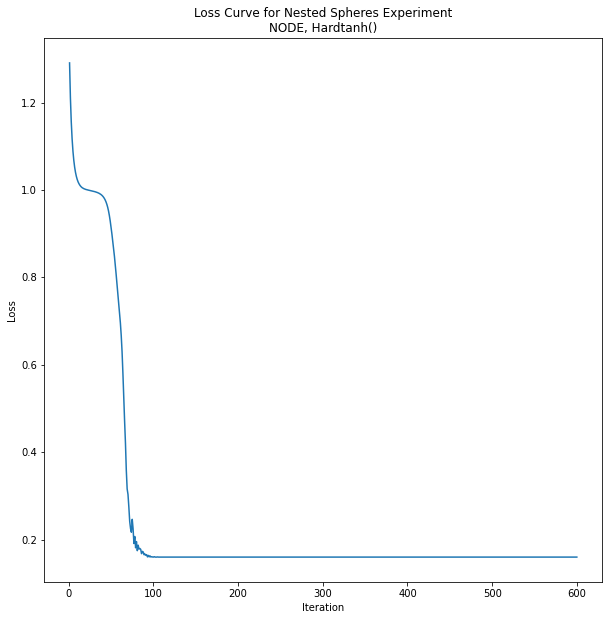

In [74]:
iters = np.linspace(1,600,600)

plt.figure(figsize=[10,10])
plt.plot(iters, loss_data)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Nested Spheres Experiment\nNODE, Hardtanh()')
plt.savefig('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/experiment_1/node/loss_curve.pdf')
plt.show()